<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Load</a></span></li><li><span><a href="#Guided-Backpropagation" data-toc-modified-id="Guided-Backpropagation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Guided Backpropagation</a></span></li><li><span><a href="#MNIST" data-toc-modified-id="MNIST-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#CIFAR10" data-toc-modified-id="CIFAR10-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>CIFAR10</a></span></li><li><span><a href="#Guided-GradCam" data-toc-modified-id="Guided-GradCam-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Guided GradCam</a></span><ul class="toc-item"><li><span><a href="#MNIST" data-toc-modified-id="MNIST-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#CIFAR10" data-toc-modified-id="CIFAR10-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>CIFAR10</a></span></li></ul></li></ul></div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../code')

from saliency.attribution_methods import GuidedBackprop
from saliency.ensembles import *
from utils import get_samples, visualize_saliencys

# Data Load

In [3]:
original_images_mnist, original_targets_mnist, pre_images_mnist, mnist_classes, mnist_model = get_samples('mnist')

Data Complete
Model Complete


In [4]:
original_images_cifar10, original_targets_cifar10, pre_images_cifar10, cifar10_classes, cifar10_model = get_samples('cifar10')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Data Complete
Model Complete


# Guided Backpropagation

In [5]:
GB_mnist = GuidedBackprop(mnist_model)
GB_cifar10 = GuidedBackprop(cifar10_model)

# MNIST

In [6]:
# vanilla gradients
outputs, probs, preds = GB_mnist.generate_image(pre_images_mnist, original_targets_mnist)

# ensemble
n = 50
sigma = 2
# vanilla gradients + smooth grad
outputs_SG, _, _ = generate_smooth_grad(pre_images_mnist, original_targets_mnist, n, sigma, GB_mnist)
# vanilla gradients + smooth square grad
outputs_SG_SQ, _, _ = generate_smooth_square_grad(pre_images_mnist, original_targets_mnist, n, sigma, GB_mnist)
# vanilla gradients + smooth var grad
outputs_SG_VAR, _, _ = generate_smooth_var_grad(pre_images_mnist, original_targets_mnist, n, sigma, GB_mnist)

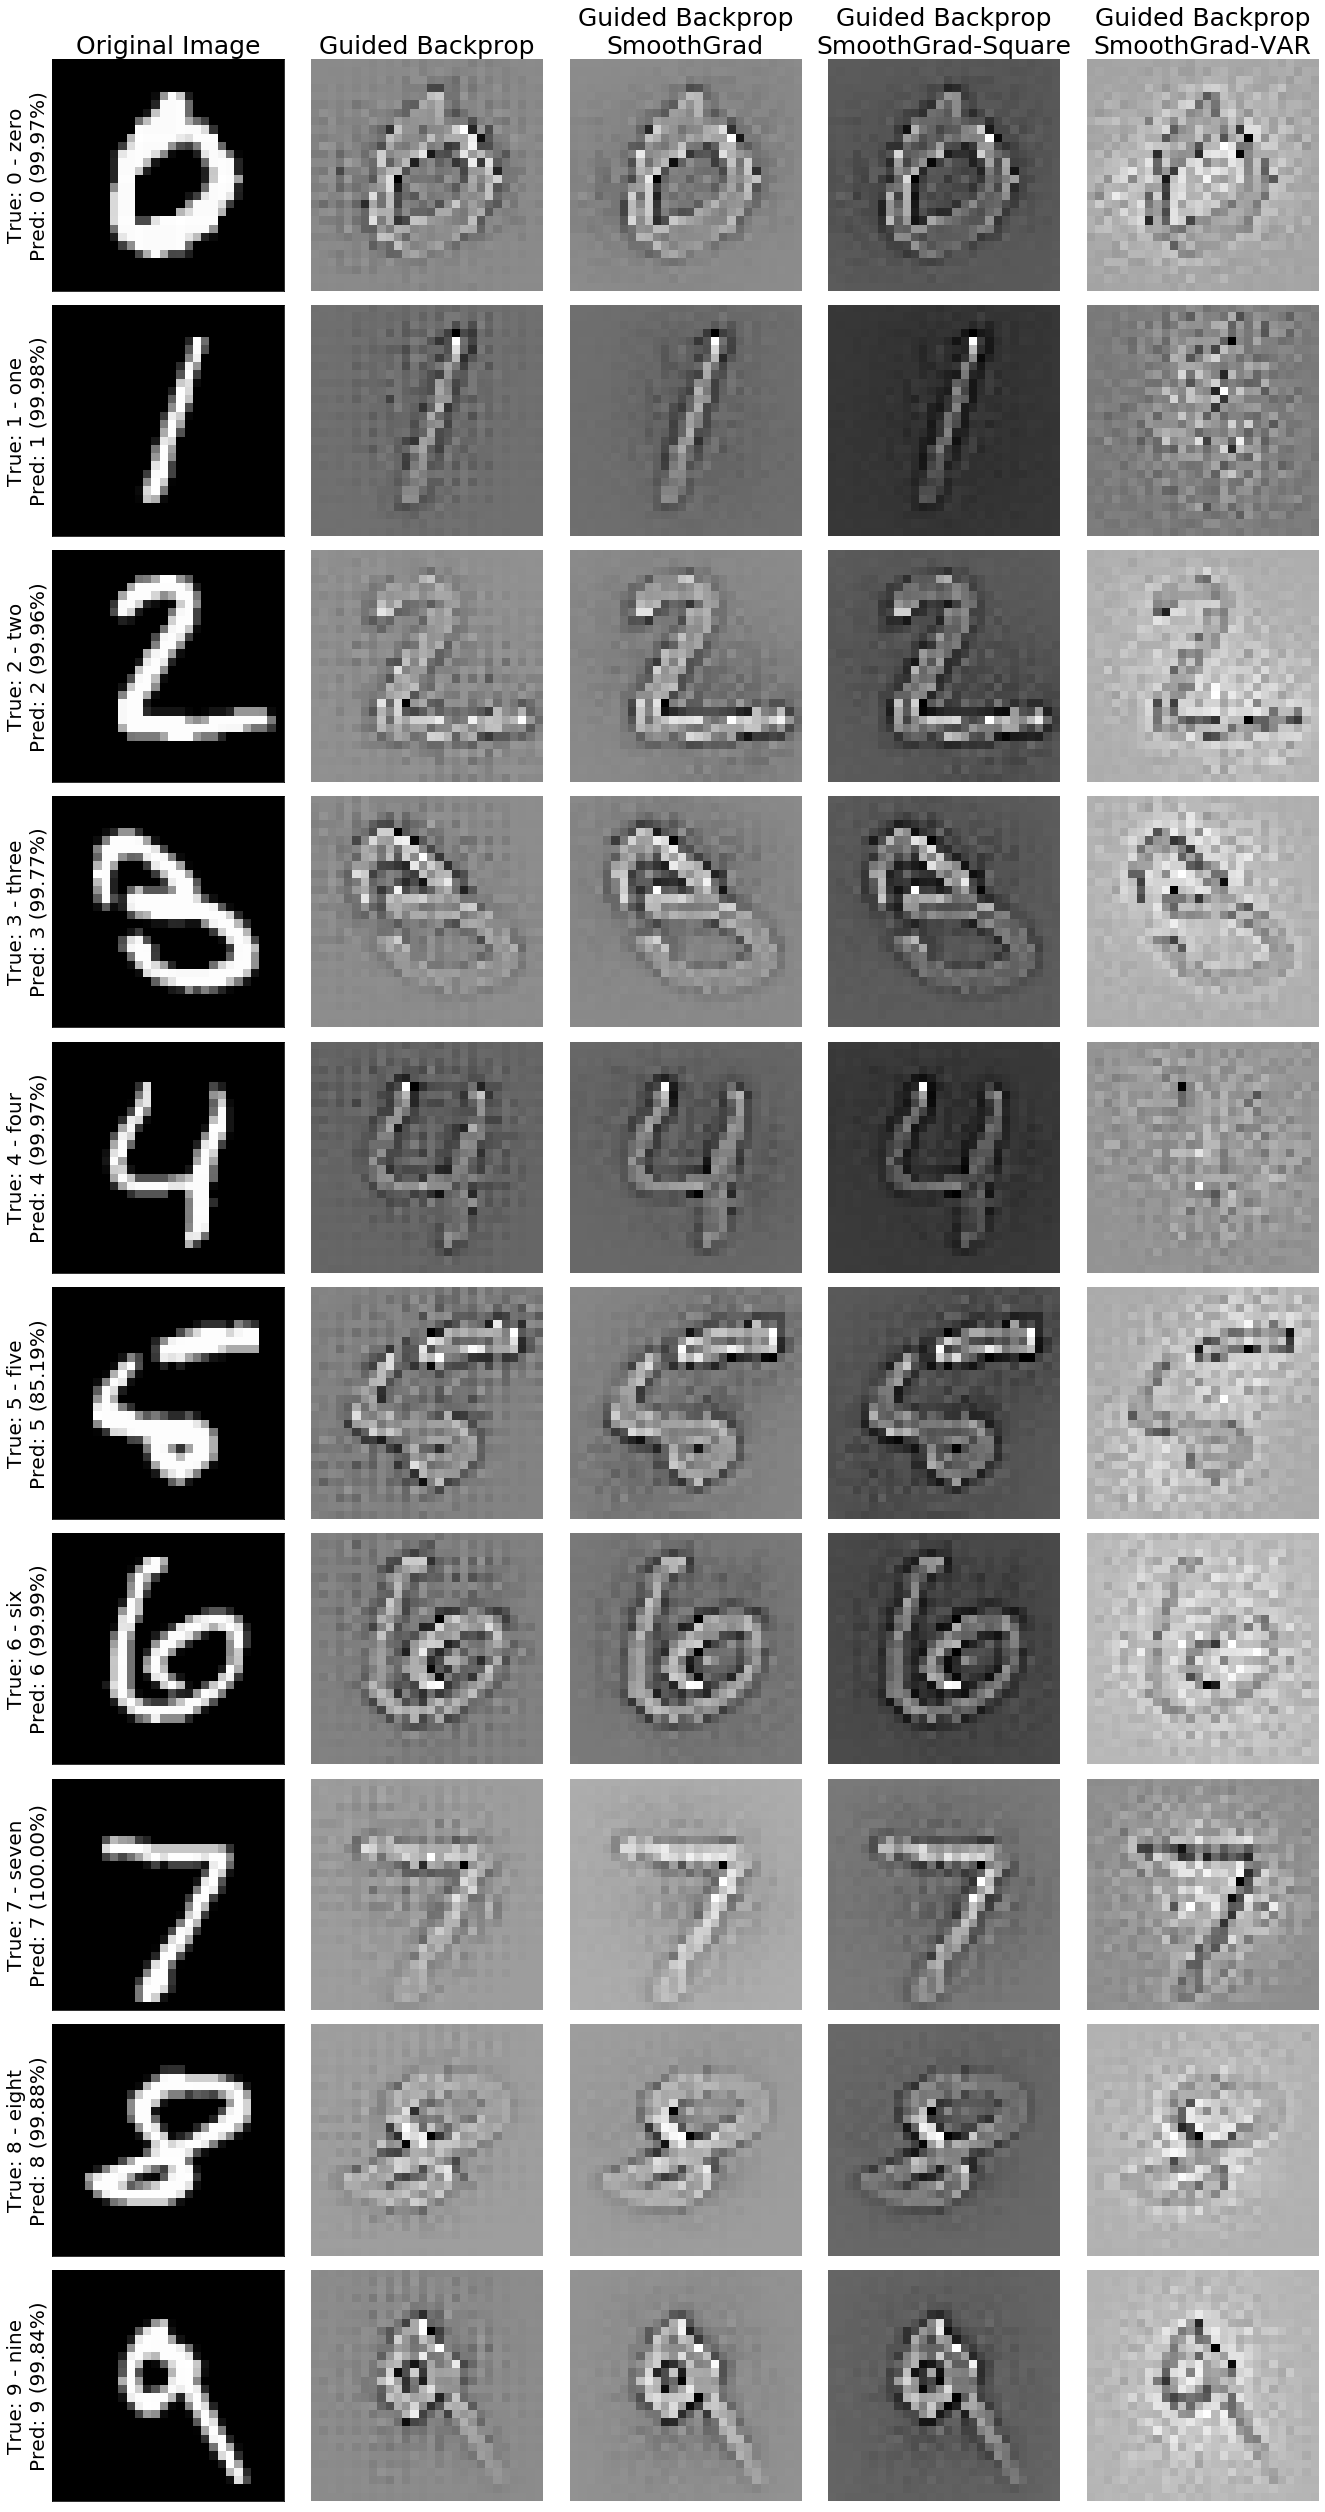

In [7]:
names = ['Guided Backprop',
         'Guided Backprop\nSmoothGrad','Guided Backprop\nSmoothGrad-Square','Guided Backprop\nSmoothGrad-VAR'] # names
results = [outputs, outputs_SG, outputs_SG_SQ, outputs_SG_VAR]
target = 'mnist'

visualize_saliencys(original_images_mnist,
                    results,
                    probs,
                    preds,
                    mnist_classes,
                    names,
                    target,
                    col=5, row=10, size=(20,35), labelsize=20, fontsize=25)

# CIFAR10

In [8]:
# vanilla gradients
outputs, probs, preds = GB_cifar10.generate_image(pre_images_cifar10, original_targets_cifar10)

# ensemble
n = 50
sigma = 2
# vanilla gradients + smooth grad
outputs_SG, _, _ = generate_smooth_grad(pre_images_cifar10, original_targets_cifar10, n, sigma, GB_cifar10)
# vanilla gradients + smooth square grad
outputs_SG_SQ, _, _ = generate_smooth_square_grad(pre_images_cifar10, original_targets_cifar10, n, sigma, GB_cifar10)
# vanilla gradients + smooth var grad
outputs_SG_VAR, _, _ = generate_smooth_var_grad(pre_images_cifar10, original_targets_cifar10, n, sigma, GB_cifar10)

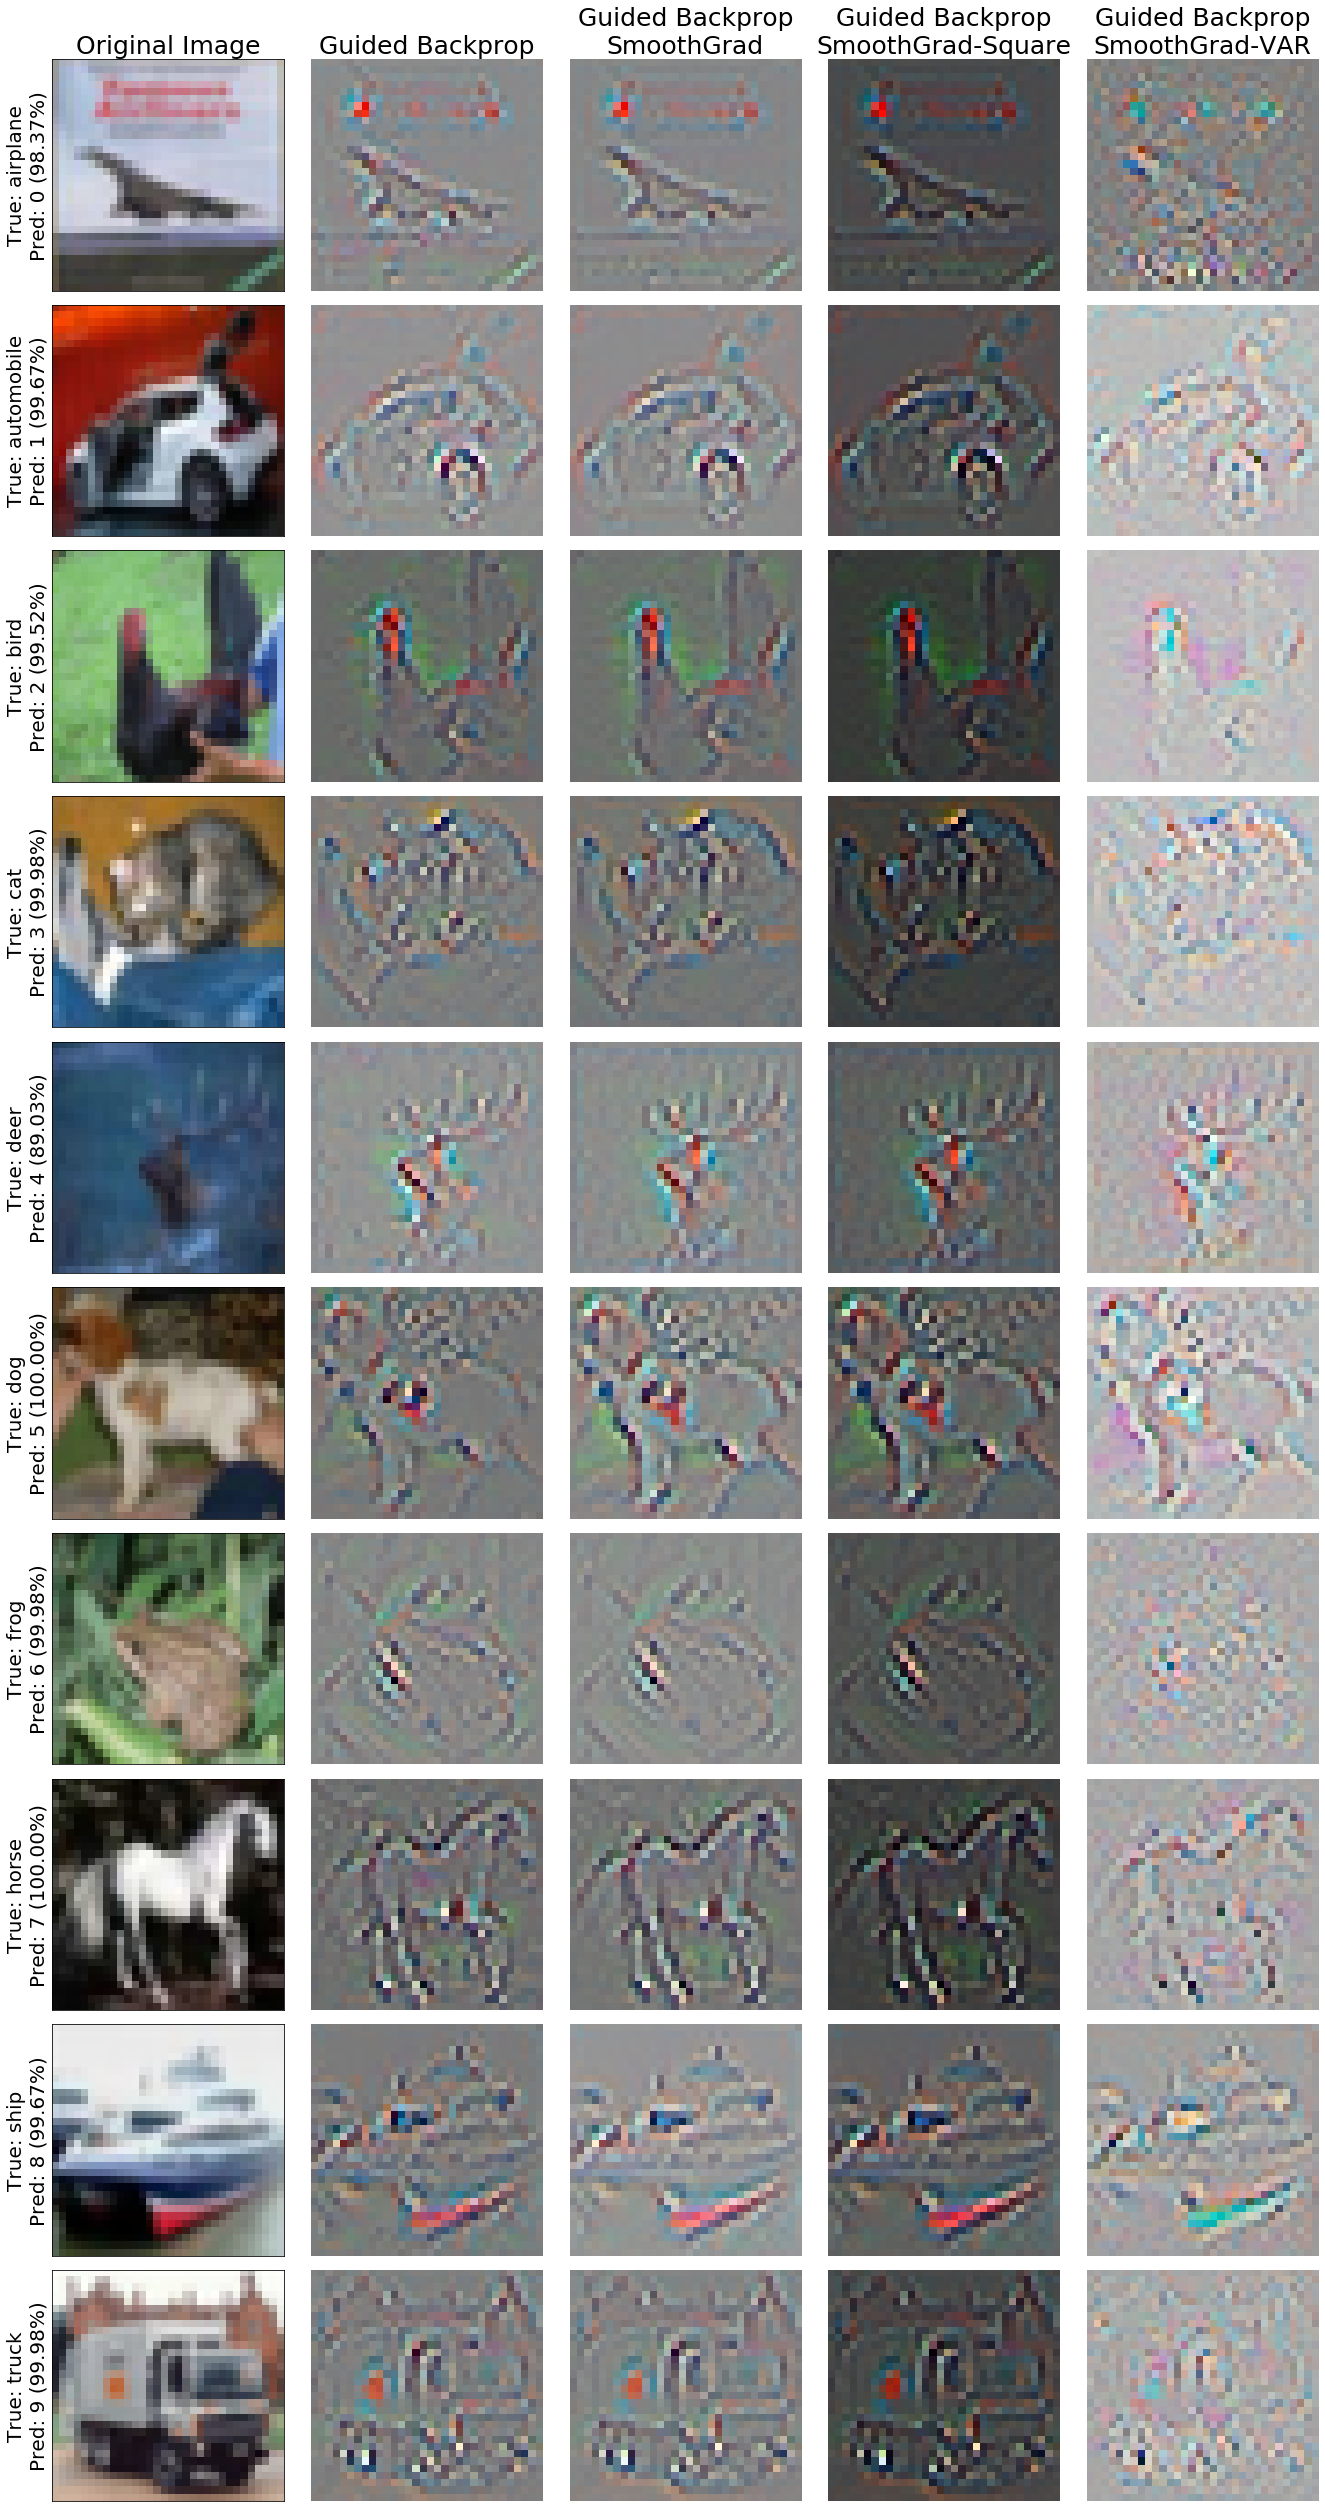

In [9]:
names = ['Guided Backprop',
         'Guided Backprop\nSmoothGrad','Guided Backprop\nSmoothGrad-Square','Guided Backprop\nSmoothGrad-VAR'] # names
results = [outputs, outputs_SG, outputs_SG_SQ, outputs_SG_VAR]
target = 'cifar10'

visualize_saliencys(original_images_cifar10,
                    results,
                    probs,
                    preds,
                    cifar10_classes,
                    names,
                    target,
                    col=5, row=10, size=(20,35), labelsize=20, fontsize=25)

# Guided GradCam

In [22]:
layers = ['Conv1','BatchNorm1','ReLU1','MaxPool1','Conv2','BatchNorm2','ReLU2','MaxPool2','Conv3','BatchNorm3','ReLU3','MaxPool3']

In [25]:
grad_cam_mnist = GradCAM(mnist_model)

In [ ]:
grad_cam_cifar10 = GradCAM(cifar10_model)

## MNIST

In [39]:
nb_class = 10
nb_layer = 12
outputs = np.zeros((nb_layer*nb_class,)+original_images_mnist.shape[1:], dtype=np.float32)
probs = np.zeros(nb_layer*nb_class)
preds = np.zeros(nb_layer*nb_class)

for layer_idx in range(nb_layer):
    for i in range(nb_class):
        img = pre_images_mnist[i].unsqueeze(0)
        
        # Guided Grad Cam = Grad Cam x Guided Backprop
        output_GC, prob, pred = grad_cam_mnist.generate_image(img, layer_idx, i)
        output_GB, _, _ = GB_mnist.generate_image(img, 0, i)
        output = np.multiply(output_GC, output_GB.transpose(2,0,1))
        output = output.transpose(1,2,0)
        
        outputs[i+(nb_class*layer_idx)] = output
        probs[i+(nb_class*layer_idx)] = prob
        preds[i+(nb_class*layer_idx)] = pred

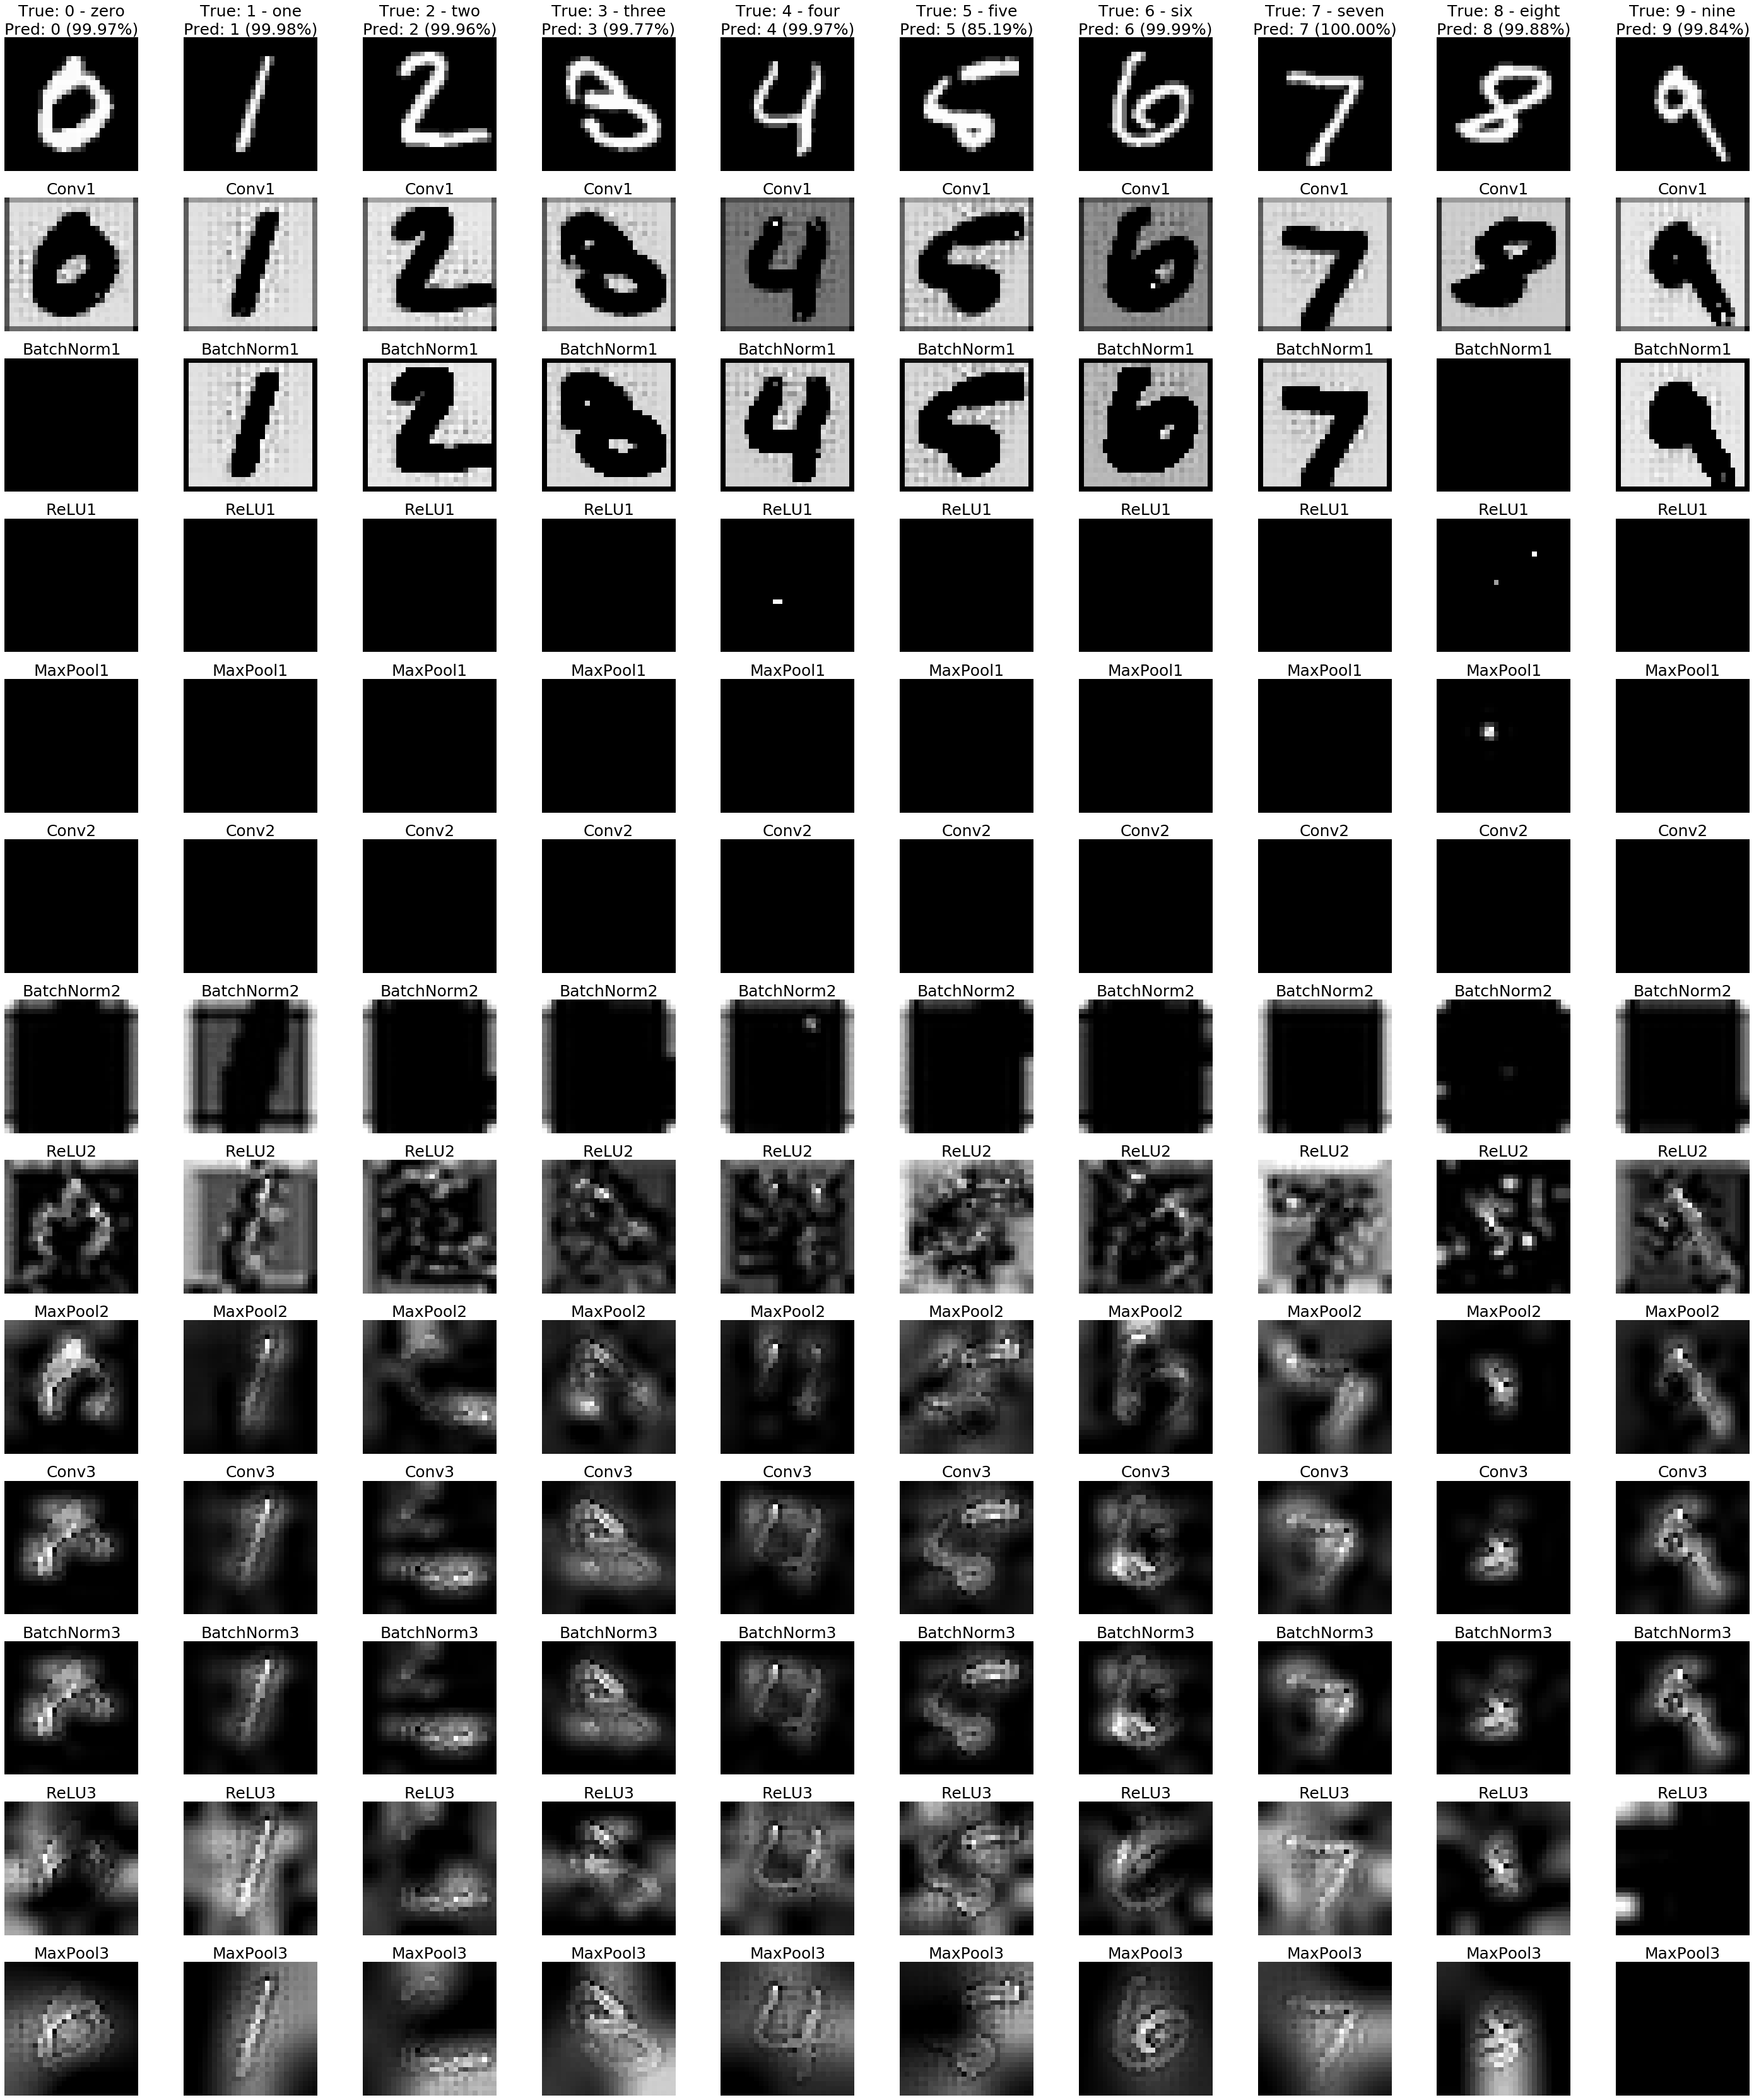

In [40]:
f, ax = plt.subplots(1+nb_layer,10,figsize=(50,5*nb_layer))
for i in range(10):
    ax[0,i].imshow(original_images_mnist[i].squeeze(), 'gray')
    ax[0,i].set_title('True: {0:}\nPred: {1:} ({2:.2%})'.format(mnist_classes[i], int(preds[i]), probs[i]), size=25)
    ax[0,i].axis('off')
for i in range(nb_layer):
    for j in range(nb_class):
        ax[i+1,j].imshow(outputs[j+(nb_class*i)].squeeze(), 'gray')
        ax[i+1,j].set_title(layers[i], size=25)
        ax[i+1,j].axis('off')

## CIFAR10

In [41]:
nb_class = 10
nb_layer = 12
outputs = np.zeros((nb_layer*nb_class,)+original_images_cifar10.shape[1:], dtype=np.float32)
probs = np.zeros(nb_layer*nb_class)
preds = np.zeros(nb_layer*nb_class)

for layer_idx in range(nb_layer):
    for i in range(nb_class):
        img = pre_images_cifar10[i].unsqueeze(0)
        
        # Guided Grad Cam = Grad Cam x Guided Backprop
        output_GC, prob, pred = grad_cam_cifar10.generate_image(img, layer_idx, i)
        output_GB, _, _ = GB_cifar10.generate_image(img, 0, i)
        output = np.multiply(output_GC, output_GB.transpose(2,0,1))
        output = output.transpose(1,2,0)
        
        outputs[i+(nb_class*layer_idx)] = output
        probs[i+(nb_class*layer_idx)] = prob
        preds[i+(nb_class*layer_idx)] = pred

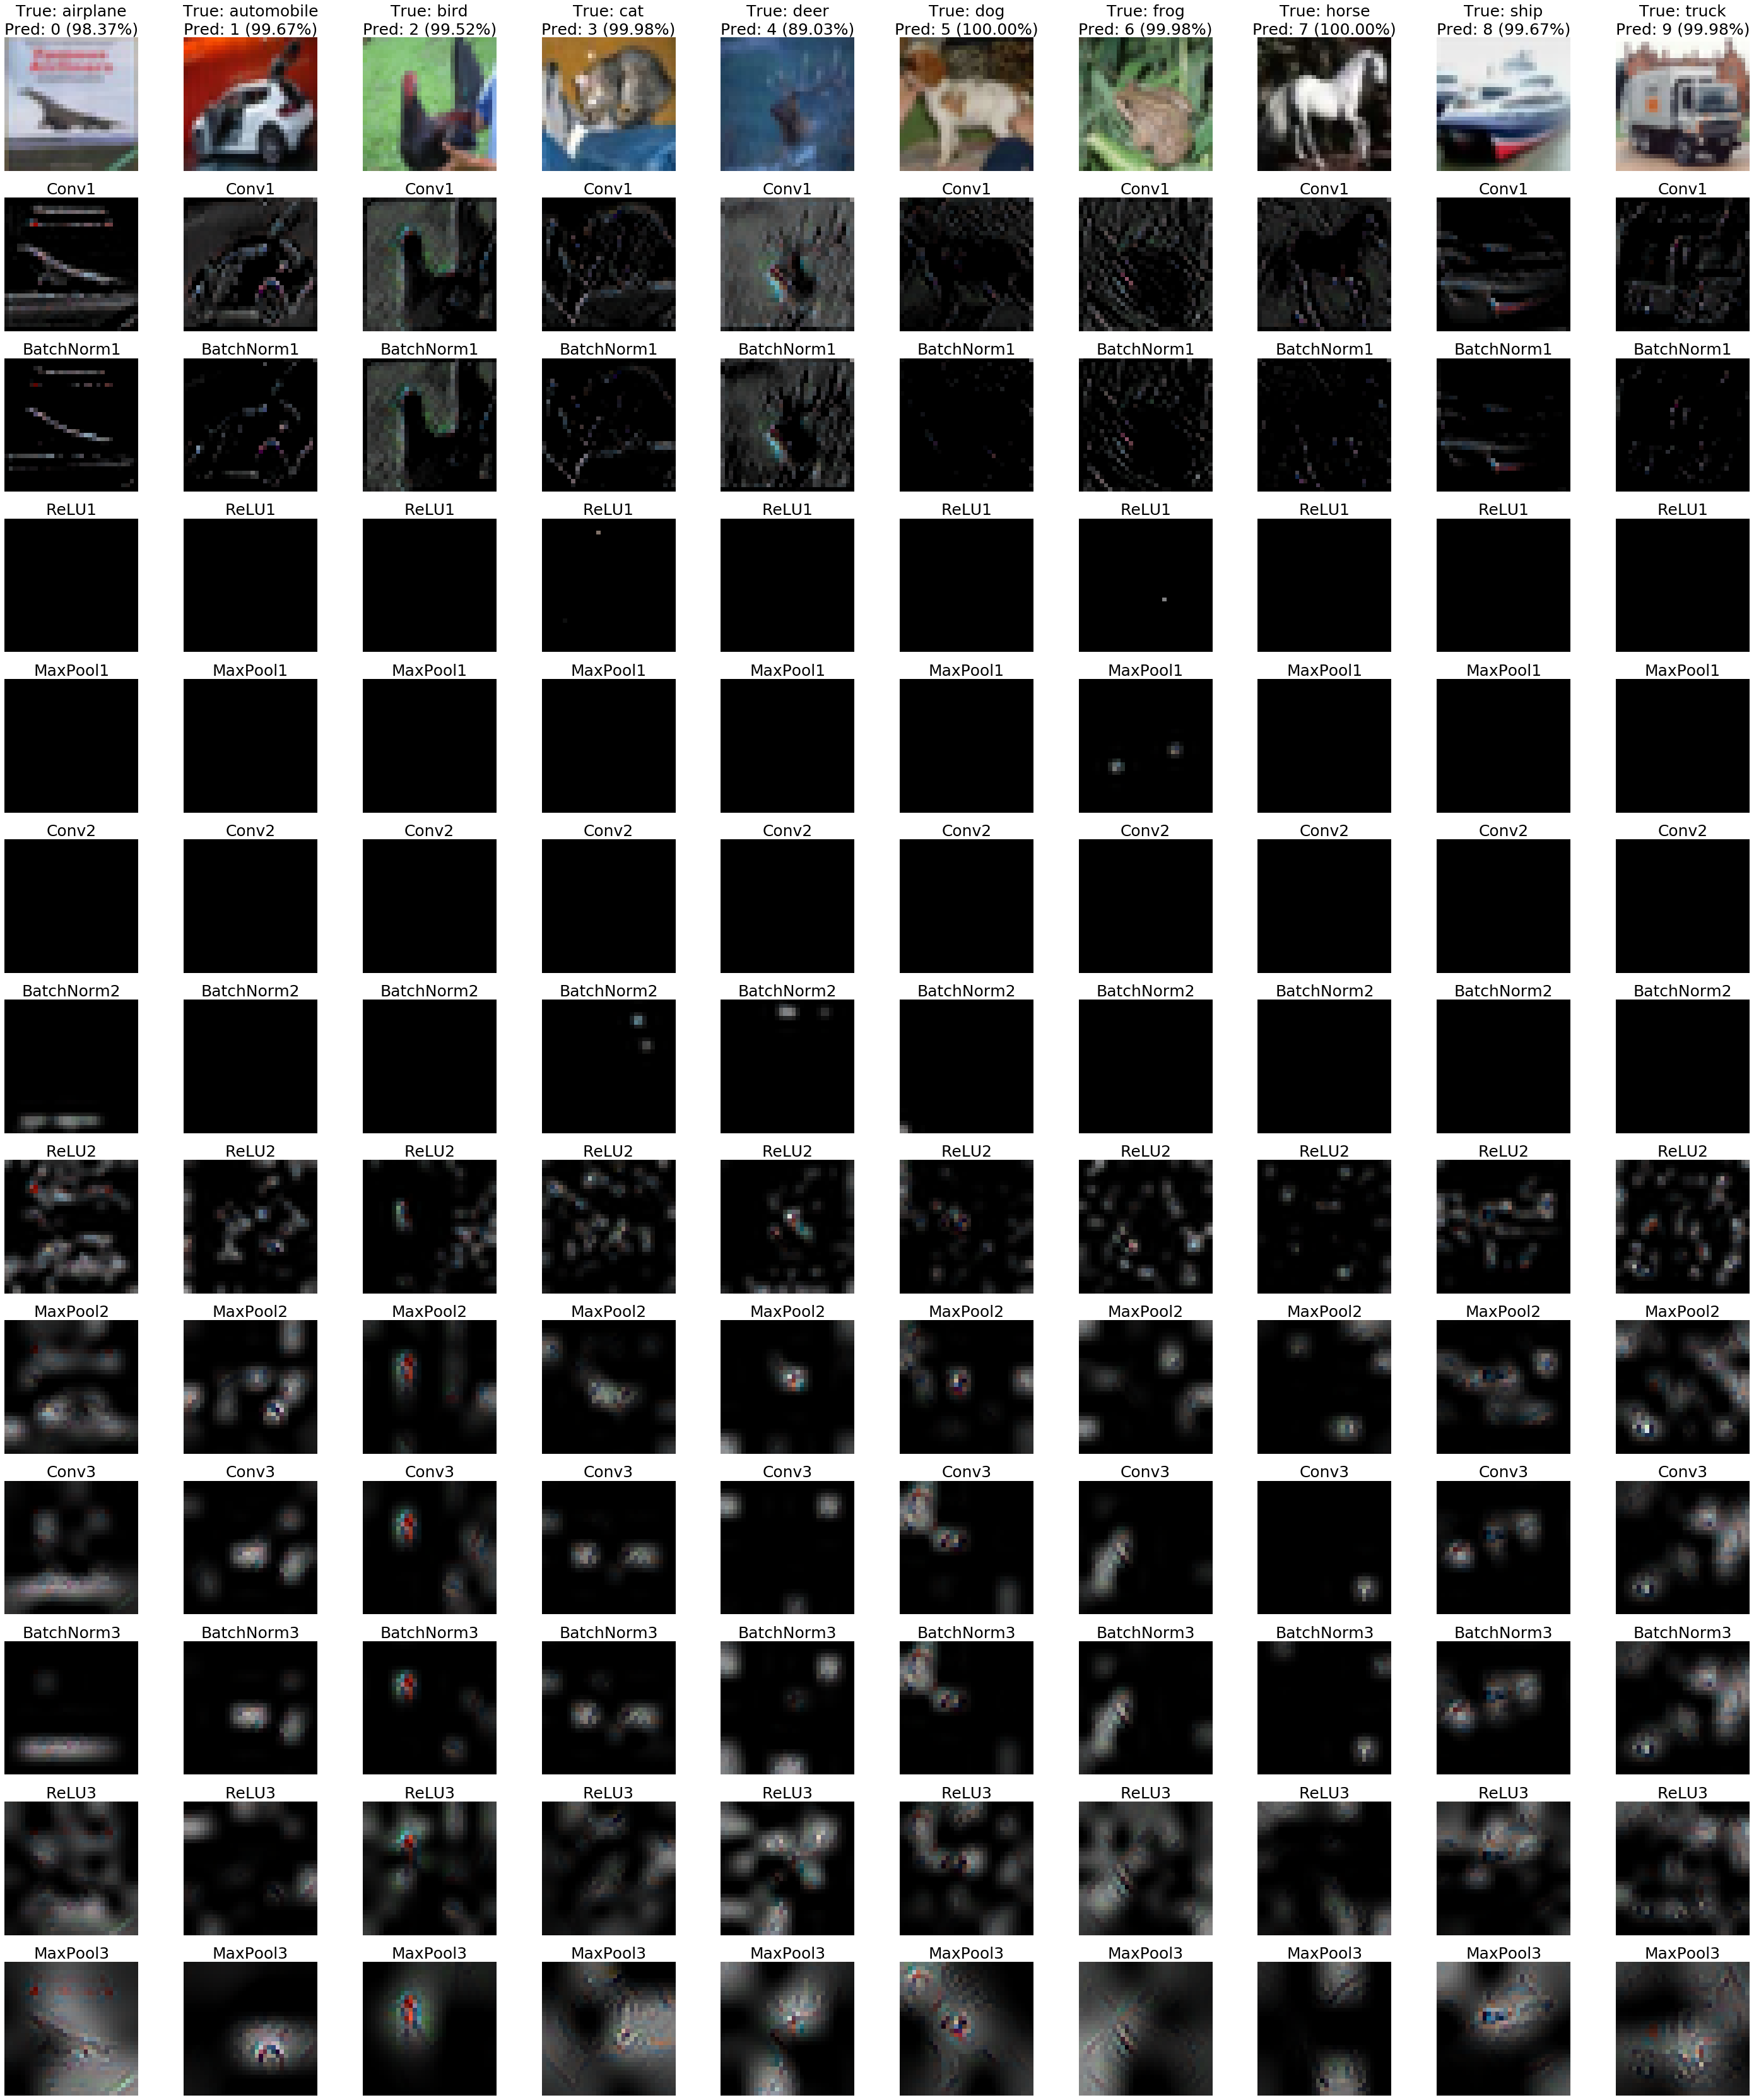

In [42]:
f, ax = plt.subplots(1+nb_layer,10,figsize=(50,5*nb_layer))
for i in range(10):
    ax[0,i].imshow(original_images_cifar10[i].squeeze())
    ax[0,i].set_title('True: {0:}\nPred: {1:} ({2:.2%})'.format(cifar10_classes[i], int(preds[i]), probs[i]), size=25)
    ax[0,i].axis('off')
for i in range(nb_layer):
    for j in range(nb_class):
        ax[i+1,j].imshow(outputs[j+(nb_class*i)])
        ax[i+1,j].set_title(layers[i], size=25)
        ax[i+1,j].axis('off')